In [1]:
# %cd Yet-Another-EfficientDet-Pytorch

In [2]:
%cd ..
# Author: Zylo117

"""
COCO-Style Evaluations

put images here datasets/your_project_name/val_set_name/*.jpg
put annotations here datasets/your_project_name/annotations/instances_{val_set_name}.json
put weights here /path/to/your/weights/*.pth
change compound_coef

"""

import json
import os

import argparse
import torch
import yaml
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, boolean_string

ap = {
    'project': 'fashion',
    'compound_coef': 0,
    'weights': 'logs/efficientdet-d0_0_712 (1).pth',
    'nms_threshold': 0.5,
    'cuda': False,
    'device': 0,
    'float16': False,
    'override': True
}
args = argparse.Namespace(**ap)

compound_coef = args.compound_coef
nms_threshold = args.nms_threshold
use_cuda = args.cuda
gpu = args.device
use_float16 = args.float16
override_prev_results = args.override
project_name = args.project
weights_path = f'weights/efficientdet-d{compound_coef}.pth' if args.weights is None else args.weights

print(f'running coco-style evaluation on project {project_name}, weights {weights_path}...')

params = yaml.safe_load(open(f'projects/{project_name}.yml'))
obj_list = params['obj_list']

input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]


/Users/kunwo/Documents/development/979/gcp/Yet-Another-EfficientDet-Pytorch
running coco-style evaluation on project fashion, weights logs/efficientdet-d0_0_712 (1).pth...


In [5]:
import cv2
import matplotlib.pyplot as plt

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, scores):
    img = image.copy()
    for bbox, category_id, score in zip(bboxes, category_ids, scores):
        if score < 0.5:
            continue
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


  0%|          | 1/1158 [00:00<18:02,  1.07it/s]

plot!


  0%|          | 2/1158 [00:01<16:49,  1.14it/s]

plot!


  0%|          | 3/1158 [00:02<16:14,  1.19it/s]

plot!


  0%|          | 3/1158 [00:03<21:14,  1.10s/it]


KeyboardInterrupt: 

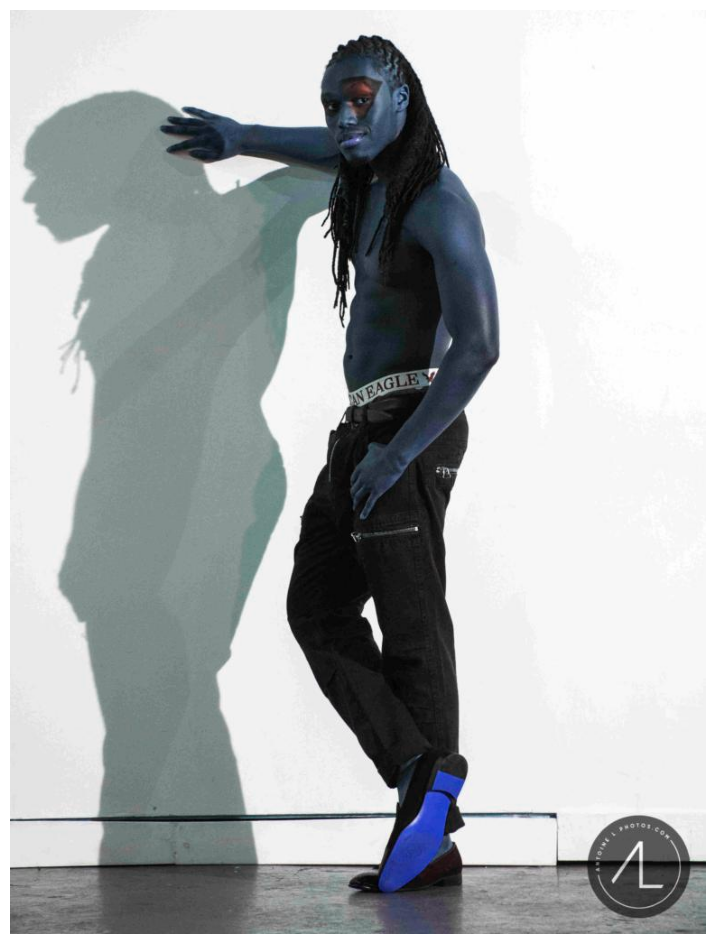

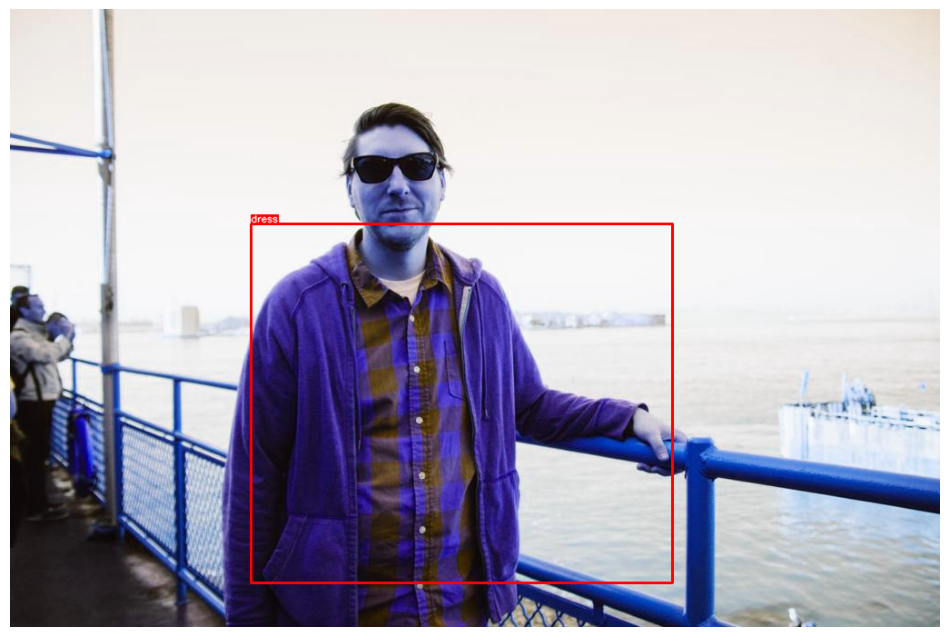

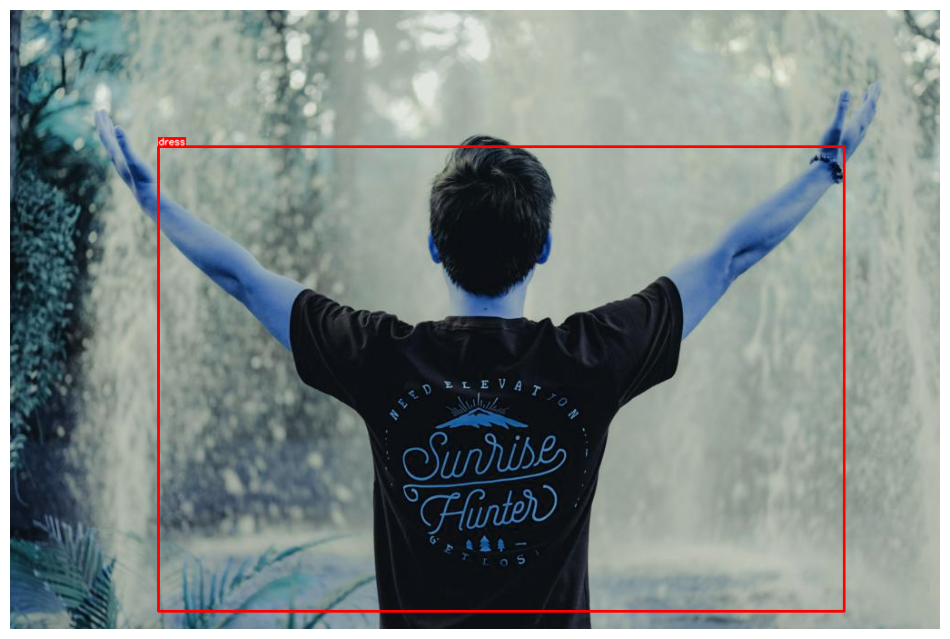

In [6]:
def evaluate_coco(img_path, set_name, image_ids, coco, model, threshold=0.05):
    results = []

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    for image_id in tqdm(image_ids[:10]):
        image_info = coco.loadImgs(image_id)[0]
        image_path = img_path + image_info['file_name']

        ori_imgs, framed_imgs, framed_metas = preprocess(image_path, max_size=input_sizes[compound_coef], mean=params['mean'], std=params['std'])
        x = torch.from_numpy(framed_imgs[0])

        if use_cuda:
            x = x
            if use_float16:
                x = x.half()
            else:
                x = x.float()
        else:
            x = x.float()

        x = x.unsqueeze(0).permute(0, 3, 1, 2)
        features, regression, classification, anchors = model(x)

        preds = postprocess(x,
                            anchors, regression, classification,
                            regressBoxes, clipBoxes,
                            threshold, nms_threshold)
        
        if not preds:
            continue

        preds = invert_affine(framed_metas, preds)[0]

        scores = preds['scores']
        class_ids = preds['class_ids']
        rois = preds['rois']

        if rois.shape[0] > 0:
            # x1,y1,x2,y2 -> x1,y1,w,h
            rois[:, 2] -= rois[:, 0]
            rois[:, 3] -= rois[:, 1]

            bbox_score = scores

            for roi_id in range(rois.shape[0]):
                score = float(bbox_score[roi_id])
                label = int(class_ids[roi_id])
                box = rois[roi_id, :]

                image_result = {
                    'image_id': image_id,
                    'category_id': label + 1,
                    'score': float(score),
                    'bbox': box.tolist(),
                }

                results.append(image_result)

            category_id_to_name = {v: k for v, k in enumerate(obj_list)}
            visualize(ori_imgs[0], rois, class_ids, category_id_to_name, scores)
            print('plot!')

    if not len(results):
        raise Exception('the model does not provide any valid output, check model architecture and the data input')

    # write output
    filepath = f'{set_name}_bbox_results.json'
    if os.path.exists(filepath):
        os.remove(filepath)
    json.dump(results, open(filepath, 'w'), indent=4)


def _eval(coco_gt, image_ids, pred_json_path):
    # load results in COCO evaluation tool
    coco_pred = coco_gt.loadRes(pred_json_path)

    # run COCO evaluation
    print('BBox')
    coco_eval = COCOeval(coco_gt, coco_pred, 'bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


if __name__ == '__main__':
    SET_NAME = params['val_set']
    VAL_GT = f'../../{params["project_name"]}/annotations/instances_attributes_{SET_NAME}.json'
    VAL_IMGS = f'../../{params["project_name"]}/{SET_NAME}/'
    MAX_IMAGES = 10000
    coco_gt = COCO(VAL_GT)
    image_ids = coco_gt.getImgIds()[:MAX_IMAGES]
    
    if override_prev_results or not os.path.exists(f'{SET_NAME}_bbox_results.json'):
        model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                                     ratios=eval(params['anchors_ratios']), scales=eval(params['anchors_scales']))
        model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
        model.requires_grad_(False)
        model.eval()

        if use_cuda:
            model.cuda(gpu)

            if use_float16:
                model.half()

        evaluate_coco(VAL_IMGS, SET_NAME, image_ids, coco_gt, model)
